<a href="https://colab.research.google.com/github/vendyliang/MachineLearningProjects/blob/master/Pharmacy_Products_Demand_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this project, we need to use the historical data to develop a model to help a pharmacy chain store with the future demand on different nutrition products. The model should provide forecasted sales amount for Summer 2016 at sku-quarter-global level. 

We are given with 3 separate files: \
(1) sales: contains weekly historical sales records since spring 2014.\
(2) products: contains the sku information for current and new products.\
(3) predict: contains the skus whose 2016 summer sales amount are to be predicted.

I will use supervised machine learning methods to build 2 models, 1 for existing products with historical sales record, and 1 for new products without such information.

# Part 0: Load Packages/Data

In [0]:
%matplotlib inline
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
#import statsmodels.formula.api as sm
import seaborn as sns
import sklearn as sl
from sklearn import preprocessing
from scipy.stats import pearsonr
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 60)
import warnings
warnings.filterwarnings('ignore')

In [0]:
# load 3 dataset with file ids
file_id='1QHLPLZSwhZLqF3qaYKPe9cFfU-0S_2YG'
link='https://drive.google.com/uc?export=download&id={FILE_ID}'
csv_url_his = link.format(FILE_ID=file_id)

file_id='18FAY6zby_oTERjT9kAK0sArkexG5eHLc'
link='https://drive.google.com/uc?export=download&id={FILE_ID}'
csv_url_pro = link.format(FILE_ID=file_id)

file_id='1tC14pD4SnaYxqJaniwHZhG0hb0K4uiIj'
link='https://drive.google.com/uc?export=download&id={FILE_ID}'
csv_url_pre = link.format(FILE_ID=file_id)

In [3]:
#read data
df_sale = pd.read_csv(csv_url_his)
df_sale.head()

,transaction_date,sku,location,quarter,sales_amt,shelf_amt
0,1/18/14,3660,GERMANY,SP2014,51,578
1,9/12/15,6159,GERMANY,FA2015,1,89
2,12/26/15,8391,GERMANY,WI2015,872,11137
3,2/6/16,8544,GERMANY,SP2016,35,121
4,7/11/15,8544,GERMANY,FA2015,0,10


In [4]:
df_product = pd.read_csv(csv_url_pro)
df_product.head()

,sku,brand,age,formation,family,sales_price,specs
0,6336,L273,ADULT,capsule,Omega3FattyAcid,138,PATENT 5726
1,8821,G633,GRADE SCHOOL,liquid,VitaminC,42,PATENT 6776|PATENT 4090|PATENT 5726
2,12,G906,ADULT,powder,Echinacea,204,PATENT 1030
3,8658,C549,TODDLER,capsule,Calcium,26,PATENT 4533
4,1860,T484,ADULT,capsule,Cranberry,47,PATENT 4533|PATENT 6776


In [5]:
df_predict = pd.read_csv(csv_url_pre)
df_predict.head()

,sku,quarter
0,8852,SU2016
1,3403,SU2016
2,7584,SU2016
3,2057,SU2016
4,3686,SU2016


# Part 1: Data Exploratoration (Descriptive)

## Understand the Raw Data / Data Cleaning

Sales dataset

In [6]:
print ("Num of rows: " + str(df_sale.shape[0])) # row count
print ("Num of columns: " + str(df_sale.shape[1])) # col count
print ('Unique num of SKUs: ' + str(df_sale.sku.unique().size)) # different skus

Num of rows: 186836
Num of columns: 6
Unique num of SKUs: 320


Product dataset

In [7]:
print ("Num of rows: " + str(df_product.shape[0])) # row count
print ("Num of columns: " + str(df_product.shape[1])) # col count
print ('Unique num of SKUs: ' + str(df_product.sku.unique().size)) # different skus

Num of rows: 407
Num of columns: 7
Unique num of SKUs: 407


Predict dataset

In [8]:
print ("Num of rows: " + str(df_predict.shape[0])) # row count
print ("Num of columns: " + str(df_predict.shape[1])) # col count
print ('Unique num of SKUs: ' + str(df_predict.sku.unique().size)) # different skus

Num of rows: 407
Num of columns: 2
Unique num of SKUs: 407


The product dataset contains all 407 skus. The sales dataset contains only 320 skus with sales records. And the predict file contains all 407 skus. Next we will mark all skus into 2 buckets: the 320 existing skus and the 87 newly launched skus.

### Check for missing values or NaN

In [10]:
df_sale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186836 entries, 0 to 186835
Data columns (total 6 columns):
transaction_date    186836 non-null object
sku                 186836 non-null int64
location            186836 non-null object
quarter             186836 non-null object
sales_amt           186836 non-null int64
shelf_amt           186836 non-null int64
dtypes: int64(3), object(3)
memory usage: 8.6+ MB


In [11]:
df_sale.describe()

,sku,sales_amt,shelf_amt
count,186836.000,186836.000,186836.000
mean,5141.013,233.403,3797.877
std,2837.154,975.853,11400.378
min,12.000,0.000,0.000
25%,2786.000,1.000,15.000
50%,4861.000,15.000,254.000
75%,7685.000,127.000,2315.000
max,9974.000,103491.000,272647.000


In [12]:
print (df_sale.isnull().sum(axis = 0))
print (df_product.isnull().sum(axis = 0))
print (df_predict.isnull().sum(axis = 0))

transaction_date    0
sku                 0
location            0
quarter             0
sales_amt           0
shelf_amt           0
dtype: int64
sku            0
brand          0
age            0
formation      0
family         0
sales_price    0
specs          0
dtype: int64
sku        0
quarter    0
dtype: int64


There is no NaN across all 3 datasets. There are 0s in the sales dataset but it is reasonable because there could be no sales_amt at all for some products. Therefore, I'd assume that there is NO missing data in this case.

### Check for duplication

In [12]:
lst = [df_sale, df_product, df_predict]
for i in range(len(lst)):
    print ('Num of duplication: ' + str(lst[i].duplicated().sum()))

Num of duplication: 1808
Num of duplication: 0
Num of duplication: 0


We can see that there are duplicated skus in the sales dataset. This is reasonable because a sku has different weeks' records and locations. We will need to group the weeks by quarter in the next step.

### Prepare dataframes for Existing and New products

Existing 320 skus: products with historical sales data\
New 87 skus:       products without historical sales data\
total 407

In [9]:
ex_sku_blmask = df_predict['sku'].isin(df_sale['sku'])
ex_sku_blmask

0      True
1      True
2      True
3      True
4      True
       ... 
402    True
403    True
404    True
405    True
406    True
Name: sku, Length: 407, dtype: bool

In [10]:
nw_sku_blmask = ~ex_sku_blmask # ~ is not
nw_sku_blmask

0      False
1      False
2      False
3      False
4      False
       ...  
402    False
403    False
404    False
405    False
406    False
Name: sku, Length: 407, dtype: bool

In [11]:
print('Num of existing products: ', ex_sku_blmask.sum())
print('Num of new products: \t', nw_sku_blmask.sum())

Num of existing products:  320
Num of new products: 	 87


Join tables (combine sales and product dataset together for existing products)

In [0]:
# aggregate sales from weekly to quarterly
function = {'sales_amt': 'sum', 'shelf_amt': 'sum'}
sales_qrt = df_sale.groupby(['sku','location','quarter'], as_index = False).agg(function)

In [13]:
print('Num of rows before aggregation: ', df_sale.shape[0])
print('Num of rows after aggregation: ', sales_qrt.shape[0])

Num of rows before aggregation:  186836
Num of rows after aggregation:  6942


In [11]:
sales_qrt

,sku,location,quarter,sales_amt,shelf_amt
0,12,GERMANY,SP2016,0,14
1,12,RUSSIA,SP2016,11,66
2,12,SPAIN,FA2015,0,12
3,12,SPAIN,SP2016,0,47
4,12,SPAIN,WI2015,0,32
...,...,...,...,...,...
6937,9974,SPAIN,FA2015,3,162
6938,9974,SPAIN,SP2016,24,1536
6939,9974,SPAIN,WI2015,68,2231
6940,9974,UNITED KINGDOM,SP2016,13,112


In [15]:
# merge sales dataset with product dataset into one table for existing skus
ex_combine = sales_qrt.merge(df_product, on = ['sku'], how = 'left')
ex_combine.head(2)

,sku,location,quarter,sales_amt,shelf_amt,brand,age,formation,family,sales_price,specs
0,12,GERMANY,SP2016,0,14,G906,ADULT,powder,Echinacea,204,PATENT 1030
1,12,RUSSIA,SP2016,11,66,G906,ADULT,powder,Echinacea,204,PATENT 1030


In [14]:
# double check missing values after left join
print (ex_combine.isnull().sum())

sku            0
location       0
quarter        0
sales_amt      0
shelf_amt      0
brand          0
age            0
formation      0
family         0
sales_price    0
specs          0
dtype: int64


From product dataset, get the info on new products (sales data not available)

In [16]:
nw = df_product[nw_sku_blmask]
nw.head(2)

,sku,brand,age,formation,family,sales_price,specs
5,2778,P415,GRADE SCHOOL,powder,FishOil,77,PATENT 2876|PATENT 5726|PATENT 456
8,7158,C317,ADULT,powder,Zinc,229,PATENT 2876


## Distribution and Correlation

### Response Varieble - sales_amt

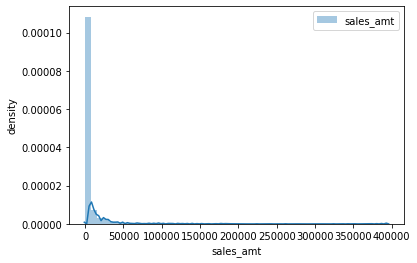

In [23]:
# distribution of sales_amt
sns.distplot(ex_combine['sales_amt'], label = 'sales_amt')
plt.legend(loc = 'upper right')
plt.ylabel('density')
plt.show()

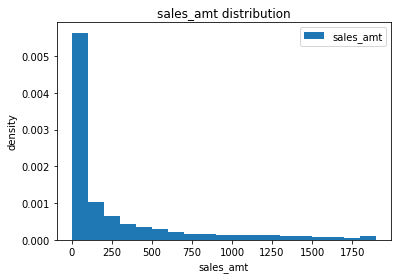

In [24]:
# histogram for sales_amt with range (0, 2000)

plt.hist(ex_combine['sales_amt'].values, bins = range(0, 2000, 100), label = 'sales_amt', density = True)
plt.legend(loc = 'upper right')
plt.xlabel('sales_amt')
plt.ylabel('density')
plt.title('sales_amt distribution')
plt.show()

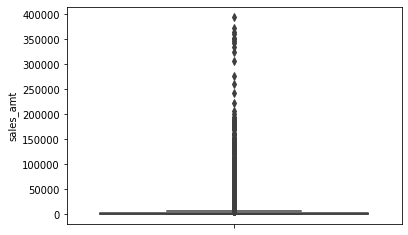

In [25]:
# check outlier
sns.boxplot(ex_combine.sales_amt, orient = 'v')

### Numerical Features and Feature Correlation

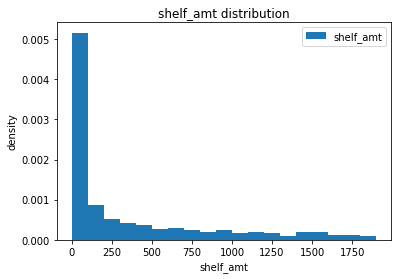

In [26]:
# shelf_amt
plt.hist(ex_combine['shelf_amt'].values, bins = range(0, 2000, 100), label = 'shelf_amt', density = True)
plt.legend(loc = 'upper right')
plt.xlabel('shelf_amt')
plt.ylabel('density')
plt.title('shelf_amt distribution')
plt.show()

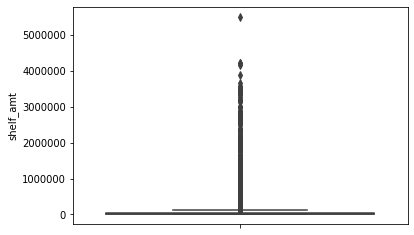

In [27]:
sns.boxplot(ex_combine.shelf_amt, orient = 'v')

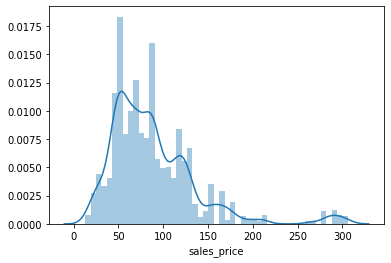

In [28]:
# sales_price
sns.distplot(ex_combine['sales_price'])

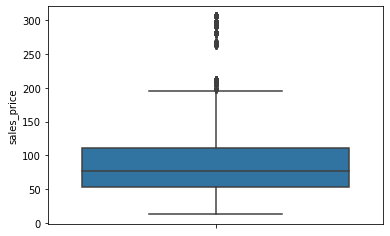

In [29]:
sns.boxplot(ex_combine.sales_price, orient = 'v')

In [0]:
corr = ex_combine[['sales_amt', 'shelf_amt', 'sales_price']].corr()

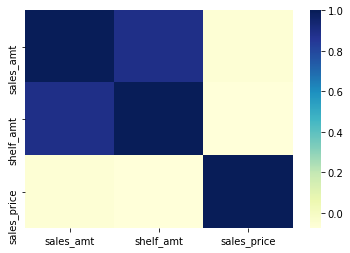

In [32]:
sns.heatmap(corr, cmap="YlGnBu")

In [33]:
corr

,sales_amt,shelf_amt,sales_price
sales_amt,1.000,0.891,-0.054
shelf_amt,0.891,1.000,-0.075
sales_price,-0.054,-0.075,1.000


In [34]:
from scipy.stats import pearsonr
print (pearsonr(ex_combine['sales_amt'], ex_combine['shelf_amt']))

(0.8910999154139893, 0.0)


The correlation coefficient between 'sales_amt' and 'shelf_amt' is 0.89 and p-value is 0.00. This means that they are strongly correlated and that 'shelf_amt' can explain most of the variation in 'sales_amt'.

### Categorical Features

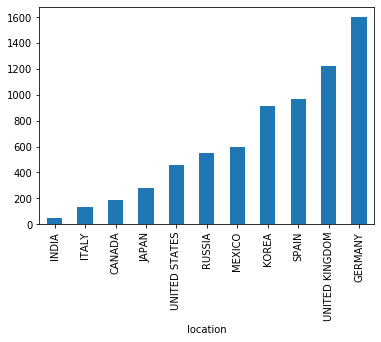

In [36]:
# check number of sales records by country
# ex_combine.groupby('location').size().plot.bar() + sort_values()
ex_combine.groupby('location').size().sort_values().plot.bar()

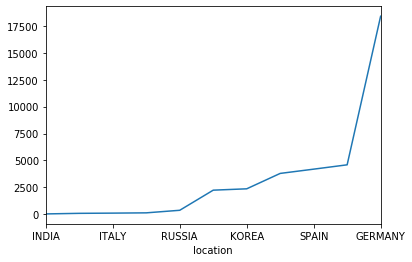

In [37]:
# distrbution of sales_amt by location
ex_combine.sales_amt.groupby(ex_combine['location']).mean().sort_values().plot()

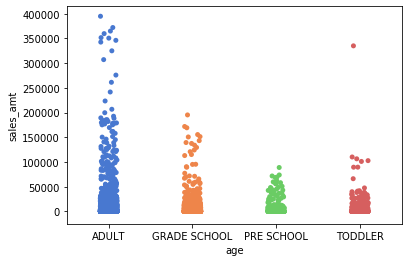

,index,age
0,ADULT,4491
1,GRADE SCHOOL,1421
2,TODDLER,597
3,PRE SCHOOL,433


In [38]:
sns.stripplot(x = 'age', y = 'sales_amt', data = ex_combine, jitter = True, palette = 'muted')
plt.show()
ex_combine['age'].value_counts().reset_index()

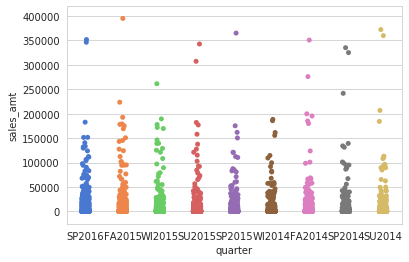

,index,quarter
0,SP2016,1364
1,WI2015,1185
2,FA2015,993
3,SU2015,848
4,SP2015,672
5,WI2014,575
6,FA2014,497
7,SU2014,442
8,SP2014,366


In [89]:
sns.stripplot(x = 'quarter', y = 'sales_amt', data = ex_combine, jitter = True, palette = 'muted')
plt.show()
ex_combine['quarter'].value_counts().reset_index()

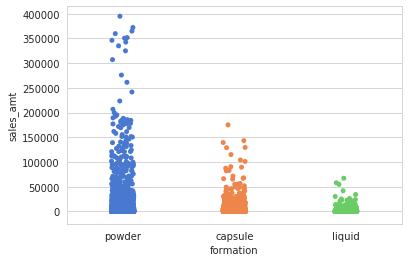

,index,formation
0,powder,4856
1,capsule,1623
2,liquid,463


In [93]:
sns.stripplot(x = 'formation', y = 'sales_amt', data = ex_combine, jitter = True, palette = 'muted')
plt.show()
ex_combine['formation'].value_counts().reset_index()

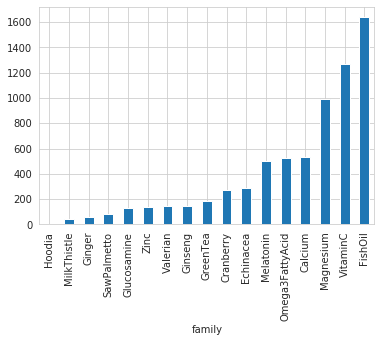

In [97]:
ex_combine.groupby('family').size().sort_values().plot.bar()

In [0]:
#ref

for i in ['location','quarter','age','brand','formation','family']:
    sns.countplot(x = i, data = ex_combine, order = ex_combine[i].value_counts().index)
    plt.xticks(rotation = 90)
    plt.title('Count of {}'.format(i))
    plt.show()
    sns.stripplot(x = i, y = 'sales_amt', data = ex_combine, jitter = True, order = ex_combine[i].value_counts().index)
    plt.xticks(rotation = 90)
    plt.title('Sales by {}'.format(i))
    plt.show()

The 'specs' feature cantains multiple specs. We can split each and every different spec out and make into individual features in the feature preprocessing step.

In [40]:
bar_chart = ex_combine['specs'].str.get_dummies(sep='|').sum()
bar_chart

PATENT 1030     313
PATENT 2461     105
PATENT 2876    1426
PATENT 3279      13
PATENT 4090    2320
PATENT 4533    2629
PATENT 456     1340
PATENT 4566     163
PATENT 5281      99
PATENT 5514     360
PATENT 5726     925
PATENT 6776     422
PATENT 7883      37
PATENT 8830    2464
PATENT 8895      25
PATENT 8924     113
PATENT 8998      25
PATENT 9404      32
PATENT 9545      11
PATENT 9568      85
dtype: int64

Text(0.5, 0, 'specs')

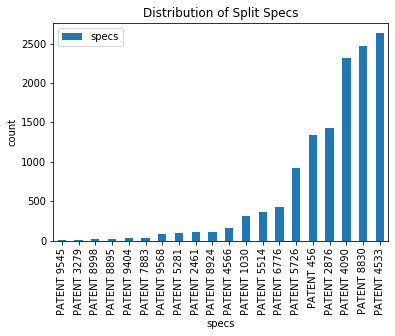

In [41]:
bar_chart.sort_values(ascending=True).plot.bar(label = 'specs')
plt.title('Distribution of Split Specs')
plt.legend(loc = 'upper left')
plt.ylabel('count')
plt.xlabel('specs')

In [42]:
print('There are ' + str(ex_combine['specs'].str.get_dummies(sep='|').columns.shape[0]) + ' individual specs after splitting')

There are 20 individual specs after splitting


In [0]:
#ref on brand
bar_chart2 = ex_combine.brand.value_counts()

In [59]:
#ref on brand
bar_chart2

B338    607
G633    580
Y83     488
B538    444
C319    291
       ... 
G906      5
F29       4
V891      4
C549      2
G333      2
Name: brand, Length: 105, dtype: int64

Text(0.5, 0, 'brand')

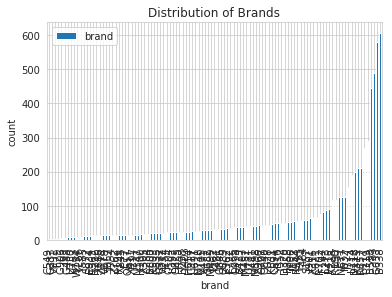

In [125]:
#ref on brand
bar_chart2.sort_values(ascending=True).plot.bar(label = 'brand')
plt.title('Distribution of Brands')
plt.legend(loc = 'upper left')
plt.ylabel('count')
plt.xlabel('brand')

In [128]:
#ref on brand
bar_chart2.count()

105

In [134]:
#ref on brand
ex_combine['brand'].value_counts().reset_index().head(10)

,index,brand
0,B338,607
1,G633,580
2,Y83,488
3,B538,444
4,C319,291
5,U117,268
6,R857,212
7,X315,211
8,D118,199
9,L214,189


#Part 2: Feature Preprocessing

We need to process the features for modeling
1. Break 'quarter' down to 'year' and 'season'
2. Bucketize 'sales_price' as its spread is large
3. Transform categorical features to dummy intervals with numerical values


In [0]:
# quarter => year + season

ex_combine_1 = ex_combine.copy(deep = True)
ex_combine_1['season'] = ex_combine_1['quarter'].astype(str).str[0:2]
ex_combine_1['year'] = ex_combine_1['quarter'].astype(str).str[2:7]
# will drop quarter in the training and testing data at later steps

In [18]:
ex_combine_1.head()

,sku,location,quarter,sales_amt,shelf_amt,brand,age,formation,family,sales_price,specs,season,year
0,12,GERMANY,SP2016,0,14,G906,ADULT,powder,Echinacea,204,PATENT 1030,SP,2016
1,12,RUSSIA,SP2016,11,66,G906,ADULT,powder,Echinacea,204,PATENT 1030,SP,2016
2,12,SPAIN,FA2015,0,12,G906,ADULT,powder,Echinacea,204,PATENT 1030,FA,2015
3,12,SPAIN,SP2016,0,47,G906,ADULT,powder,Echinacea,204,PATENT 1030,SP,2016
4,12,SPAIN,WI2015,0,32,G906,ADULT,powder,Echinacea,204,PATENT 1030,WI,2015


In [19]:
# sales_amt
ex_combine_1['sales_price'].describe(percentiles = [.1, .2, .3, .4, .5, .6, .7, .8, .9])

count   6942.000
mean      88.377
std       49.898
min       13.000
10%       44.000
20%       51.000
30%       58.000
40%       69.000
50%       77.000
60%       88.600
70%      101.000
80%      119.000
90%      143.000
max      306.000
Name: sales_price, dtype: float64

In [0]:
# bin sales_price into 10 buckets
bin_price = [13, 44, 51, 58, 69, 77, 88, 101, 119, 143, 306]
price_label_name = ['<= $44', '$44-51', '$51-58', '$58-69', '$69-77', '$77-88', '$88-101', '$101-119', '$119-143', ' >= $143']
bin = pd.cut(ex_combine_1['sales_price'], bin_price, labels = price_label_name) #the value of each row turned from certain price to one of the 10 buckets

In [21]:
bin

0        >= $143
1        >= $143
2        >= $143
3        >= $143
4        >= $143
          ...   
6937    $119-143
6938    $119-143
6939    $119-143
6940    $119-143
6941    $119-143
Name: sales_price, Length: 6942, dtype: category
Categories (10, object): [<= $44 < $44-51 < $51-58 < $58-69 ... $88-101 < $101-119 < $119-143 < >= $143]

In [0]:
d_price = pd.get_dummies(bin)

In [0]:
# simple categorical features
d_location = pd.get_dummies(ex_combine_1['location'])
d_age = pd.get_dummies(ex_combine_1['age'])
d_formation = pd.get_dummies(ex_combine_1['formation'])
d_family = pd.get_dummies(ex_combine_1['family'])
d_brand = pd.get_dummies(ex_combine_1['brand'])
d_year = pd.get_dummies(ex_combine_1['year'])
d_season = pd.get_dummies(ex_combine_1['season'])

In [0]:
# spec features
d_spec = ex_combine_1['specs'].str.get_dummies(sep='|')

In [0]:
# drop
temp = ex_combine_1.drop(['sales_price', 'location', 'age', 'formation', 'family', 'brand', 'specs', 'season', 'year'], axis =1)

In [0]:
# concat
new_ex_combine = pd.concat([temp, d_price, d_location, d_age, d_formation, d_family, d_brand, d_spec, d_year, d_season], axis = 1)

In [28]:
new_ex_combine.head()

,sku,quarter,sales_amt,shelf_amt,<= $44,$44-51,$51-58,$58-69,$69-77,$77-88,$88-101,$101-119,$119-143,>= $143,CANADA,GERMANY,INDIA,ITALY,JAPAN,KOREA,MEXICO,RUSSIA,SPAIN,UNITED KINGDOM,UNITED STATES,ADULT,GRADE SCHOOL,PRE SCHOOL,TODDLER,capsule,...,Z762,Z778,Z966,PATENT 1030,PATENT 2461,PATENT 2876,PATENT 3279,PATENT 4090,PATENT 4533,PATENT 456,PATENT 4566,PATENT 5281,PATENT 5514,PATENT 5726,PATENT 6776,PATENT 7883,PATENT 8830,PATENT 8895,PATENT 8924,PATENT 8998,PATENT 9404,PATENT 9545,PATENT 9568,2014,2015,2016,FA,SP,SU,WI
0,12,SP2016,0,14,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1,12,SP2016,11,66,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
2,12,FA2015,0,12,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
3,12,SP2016,0,47,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
4,12,WI2015,0,32,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1


In [29]:
print('Num of features before feature processing: ', ex_combine.shape[1])
print('Num of features after feature processing: ', new_ex_combine.shape[1])

Num of features before feature processing:  11
Num of features after feature processing:  181


In [30]:
#double check any missing values
print (new_ex_combine.isnull().sum().sum())

0


nw dataset contains the product info of the 87 new skus. We need to transform the features as we did on the existing products.

In [0]:
nw1 = nw.copy(deep = True)

d_age2 = pd.get_dummies(nw1['age'])
d_formation2 = pd.get_dummies(nw1['formation'])
d_family2 = pd.get_dummies(nw1['family'])
d_brand2 = pd.get_dummies(nw1['brand'])

bin_nw = pd.cut(nw1['sales_price'], bin_price, labels = price_label_name)
d_price2 = pd.get_dummies(bin_nw)
d_spec2 = nw1['specs'].str.get_dummies(sep='|')

In [0]:
temp2 = nw1.drop(['sales_price', 'age', 'formation', 'family', 'brand', 'specs'], axis =1)
new_nw = pd.concat([temp2, d_price2, d_age2, d_formation2, d_family2, d_brand2, d_spec2], axis = 1)

In [33]:
new_nw.head()

,sku,<= $44,$44-51,$51-58,$58-69,$69-77,$77-88,$88-101,$101-119,$119-143,>= $143,ADULT,GRADE SCHOOL,PRE SCHOOL,TODDLER,capsule,liquid,powder,Calcium,Cranberry,Echinacea,FishOil,Ginger,Ginseng,Magnesium,Melatonin,MilkThistle,Omega3FattyAcid,Valerian,VitaminC,...,S157,T954,U117,U691,V891,X228,X315,X316,X411,Y481,Y585,Y83,Z362,PATENT 1030,PATENT 2461,PATENT 2876,PATENT 3279,PATENT 4090,PATENT 4533,PATENT 456,PATENT 4566,PATENT 5281,PATENT 5514,PATENT 5726,PATENT 6776,PATENT 7883,PATENT 8830,PATENT 8895,PATENT 8998,PATENT 9568
5,2778,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0
8,7158,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,7224,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
23,5674,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
30,13,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [34]:
print('Num of features before feature processing: ', nw.shape[1])
print('Num of features after feature processing: ', new_nw.shape[1])

Num of features before feature processing:  7
Num of features after feature processing:  94


Check the avergae count for each sku number (around 22)

In [35]:
new_ex_combine['sku'][new_ex_combine['sku'] == 12].count()

5

In [36]:
new_ex_combine.groupby(new_ex_combine.sku).size()

sku
12       5
37      50
81      14
147     10
206     19
        ..
9890    10
9908     6
9929     4
9956     7
9974    12
Length: 320, dtype: int64

In [37]:
new_ex_combine.groupby(new_ex_combine.sku).size().mean()

21.69375

# Part 3: Model Selection and Evaluation

Two models will be developed: \
- one for existing products
- one for new products

The existing model will be trained on only its own historical data\
The new model will be trained on the data based on similarity with the existing products

## Model for 320 Existing Products

Using data of each product to build models is not ideal, as the average data points of each product/sku is only 22. So I'd like to build complicated models that use information of all products, not just by sku.

Response variable (y) = sales_amt\
~ 20% SP2016 data will be used to evaluate the model (Testing data)

### Split dataset into Training and Testing

In [38]:
print ('SP2016 data points consists of', new_ex_combine['quarter'][new_ex_combine['quarter'] == 'SP2016'].count() / new_ex_combine.shape[0] * 100, '% of overall data points')

SP2016 data points consists of 19.64851627772976 % of overall data points


In [0]:
# select ~20% latest data for test purpose, the rest for training purpose
test = new_ex_combine[new_ex_combine['quarter'] == 'SP2016']
train = new_ex_combine[new_ex_combine['quarter'] !='SP2016']

In [0]:
# the original data lines up orderly. shuffle to make the training data random samples in the cross validation step
train = train.sample(frac = 1).reset_index(drop = True)

In [0]:
# prepare training and test data
y_train = train['sales_amt']
X_train = train.drop(['sku', 'quarter', 'sales_amt'], axis = 1) 

y_test = test['sales_amt']
X_test = test.drop(['sku', 'quarter', 'sales_amt'], axis = 1)

In [45]:
print('training data has ' + str(X_train.shape[0]) + ' observation with ' + str(X_train.shape[1]) + ' features')
print('test data has ' + str(X_test.shape[0]) + ' observation with ' + str(X_test.shape[1]) + ' features')

training data has 5578 observation with 178 features
test data has 1364 observation with 178 features


### Feature Scaling

Use Robust Scaler to scale numerical feature - shelf_amt \
I choose Robust Scaler because the values in shelf_amt have a wide range. Robust Scaling is similar to normalization but it uses the interquartile range instead, so that it is robust to outliers

In [46]:
X_train

,shelf_amt,<= $44,$44-51,$51-58,$58-69,$69-77,$77-88,$88-101,$101-119,$119-143,>= $143,CANADA,GERMANY,INDIA,ITALY,JAPAN,KOREA,MEXICO,RUSSIA,SPAIN,UNITED KINGDOM,UNITED STATES,ADULT,GRADE SCHOOL,PRE SCHOOL,TODDLER,capsule,liquid,powder,Calcium,...,Z762,Z778,Z966,PATENT 1030,PATENT 2461,PATENT 2876,PATENT 3279,PATENT 4090,PATENT 4533,PATENT 456,PATENT 4566,PATENT 5281,PATENT 5514,PATENT 5726,PATENT 6776,PATENT 7883,PATENT 8830,PATENT 8895,PATENT 8924,PATENT 8998,PATENT 9404,PATENT 9545,PATENT 9568,2014,2015,2016,FA,SP,SU,WI
0,278,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0
1,328929,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
2,85980,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0
3,101023,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
4,14,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5573,369,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0
5574,37523,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
5575,54430,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
5576,10,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0


In [0]:
# Robust scaling

from sklearn.preprocessing import RobustScaler
robust_scaler = RobustScaler()
X_train_robust = robust_scaler.fit_transform(X_train)
X_test_robust = robust_scaler.transform(X_test)

### Model Training and Evaluation

#### Use Lasso Linear Regression for quick baseline

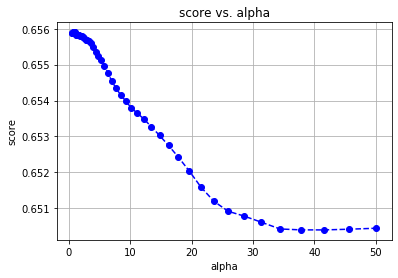

The optimaized alpha and score of Lasso linear is:  0.8808418881415119 0.6559019208850561


In [48]:
# Lasso model
from sklearn.linear_model import Lasso

alphas = np.logspace (-0.3, 1.7, num=50)
scores = np.empty_like(alphas)
opt_a = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    lasso = Lasso()
    lasso.set_params(alpha = a)
    lasso.fit(X_train_robust, y_train)
    scores[i] = lasso.score(X_test_robust, y_test)
    if scores[i] > max_score: # lasso.score is r2 
        max_score = scores[i]
        opt_a = a
        lasso_save = lasso
plt.plot(alphas, scores, color = 'b', linestyle = 'dashed', marker = 'o', markerfacecolor = 'blue', markersize = 6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
print ('The optimaized alpha and score of Lasso linear is: ', opt_a, max_score)

In [0]:
# use optimal alpha to re-train the model
lasso_f = Lasso(alpha = opt_a)
lasso_f.fit(X_train_robust, y_train)
lasso_pred = lasso_f.predict(X_test_robust)

For evaluation, we will add up all actual sales_amt and compare with all predicted_amt

In [0]:
# compare the prediction with actual sales. test has actual sales_amt.
test_compare = test.copy(deep = True)
test_compare['pred'] = np.round(lasso_pred) #predict sales_amt should be rounded
test_compare['pred'] = test_compare['pred'].clip(lower=0) #clip limits the values within a given range. lower = 0 to limit values to 0 if nagative

# aggregate sales, predicted sales by same sku, quarter
# note: our previous combined data was aggregate not only by sku, quarter but also by location for training our model
# but when we evaluate, we want to have aggrgated sales_amt only by quarter
function_2 = {'sales_amt': 'sum', 'pred': 'sum'}
test_agg = test_compare.groupby(['sku','quarter'], as_index = False).agg(function_2)

Because the actual sales_amt has a wide range, we favor MAE, MAPE, MAD ratio over MSE amd RMSE. We will also use R2 score.

In [0]:
# define MAPE and MAD_ratio, and evalution result
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/(y_true+1)))*100
    # there will be problem if y_true is 0, so we just make it +1 

def mean_absolute_deviation_ratio(y_true, y_pred):
    return y_pred.mad()/(y_true.mad()+0.1)

def evaluate(result_agg):
    MAPE = mean_absolute_percentage_error(result_agg['sales_amt'],result_agg['pred'])
    print ('MAPE of prediction in SP2016 is {}'.format(MAPE))  #MAPE
    MAE = mean_absolute_error(result_agg['sales_amt'], result_agg['pred'])
    print ('MAE of prediction in SP2016 is \t {}'.format(MAE))   # MAE
    MAD_ratio = mean_absolute_deviation_ratio(result_agg['sales_amt'],result_agg['pred'])
    print ('MAD ratio of prediction in SP2016 is {}'.format(MAD_ratio)) # MAD ratio
    R2 = r2_score(result_agg['sales_amt'],result_agg['pred'])
    print ('R squared of prediction in SP2016 is {}'.format(R2)) #R2
    MSE = mean_squared_error(result_agg['sales_amt'],result_agg['pred'])
    print ('MSE of prediction in SP2016 is {}'.format(MSE)) #MSE
    RMSE = sqrt(mean_squared_error(result_agg['sales_amt'],result_agg['pred'])) 
    print ('RMSE of prediction in SP2016 is {}'.format(RMSE))#RMSE

    
def plot_diff(result_agg, title1, title2):    # plot the pred vs. actual
    plt.plot(result_agg['pred'],'o', color='red', alpha=0.3)
    plt.plot(result_agg['sales_amt'],'*', color='blue', alpha=0.5)
    plt.title(title1)
    plt.legend(loc='upper right')
    plt.show()

    plt.plot((result_agg['pred'] - result_agg['sales_amt'])
             ,'v', color='green')
    plt.title(title2)
    plt.show()

In [53]:
evaluate(test_agg)

MAPE of prediction in SP2016 is 1188.4732652275613
MAE of prediction in SP2016 is 	 9840.169278996866
MAD ratio of prediction in SP2016 is 1.017132367390558
R squared of prediction in SP2016 is 0.7487123790185883
MSE of prediction in SP2016 is 604664238.200627
RMSE of prediction in SP2016 is 24589.921476097214


No handles with labels found to put in legend.


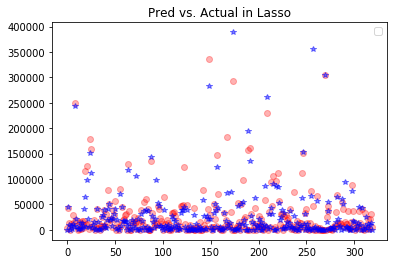

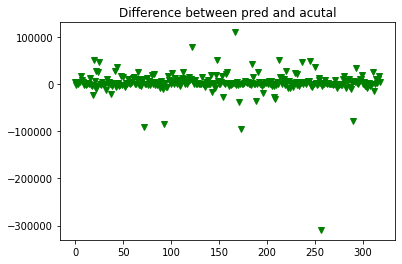

In [54]:
plot_diff(test_agg, 'Pred vs. Actual in Lasso', 'Difference between pred and acutal')

#### Non-linear Model - Random Forest

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

param_grid = {
                 'n_estimators': [5,10,15,20,30,40,50],
                 'max_depth': [30,40,45,50,55,60,70]
             }

rf = RandomForestRegressor(random_state = 2019, verbose = 1, n_jobs = 6)
grid_rf = GridSearchCV(rf, param_grid, cv = 3)
grid_rf.fit(X_train_robust, y_train)

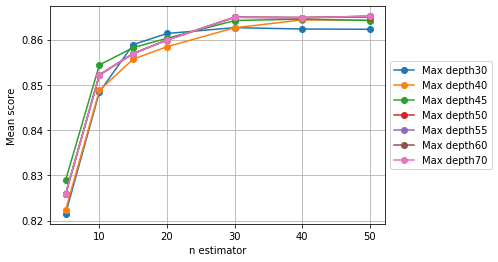

In [56]:
# plot the effect of different number of trees and maximum tree-depth druing cross validation 
scores = grid_rf.cv_results_['mean_test_score']

n_estimators = [5,10,15,20,30,40,50]
m_depth = [30,40,45,50,55,60,70]
scores = np.array(scores).reshape(len(m_depth), len(n_estimators))
fig = plt.figure()
ax = plt.subplot(111)
for idx, depth in enumerate(m_depth):
    plt.plot(n_estimators, scores[idx], '-o', label = 'Max depth' + str(depth))
    
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('n estimator')
plt.ylabel('Mean score')
plt.grid(True)
plt.show()

In [57]:
print (grid_rf.best_params_)
print (grid_rf.best_score_)

{'max_depth': 55, 'n_estimators': 50}
0.8651492300079401


In [58]:
# re-train the model with full training set
rf_best = grid_rf.best_estimator_
rf_best.fit(X_train_robust, y_train)
rf_pred = rf_best.predict(X_test_robust)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.8s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    3.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished


In [0]:
# compare the prediction with actual sales. ex_test has actual sales_amt.
test_compare2 = test.copy(deep = True)
test_compare2['pred'] = np.round(rf_pred) #predict sales_amt should be rounded
test_compare2['pred'] = test_compare2['pred'].clip(lower=0) #clip limits the values within a given range. lower = 0 to limit values to 0 if nagative

# aggregate sales, predicted sales by same sku, quarter
# note: our previous combined data was aggregate not only by sku, quarter but also by location for training our model
# but when we evaluate, we want to have aggrgated sales_amt only by quarter
function_3 = {'sales_amt': 'sum', 'pred': 'sum'}
test_agg2 = test_compare2.groupby(['sku','quarter'], as_index = False).agg(function_3)

In [60]:
evaluate(test_agg2)

MAPE of prediction in SP2016 is 89.66175414661079
MAE of prediction in SP2016 is 	 7893.219435736677
MAD ratio of prediction in SP2016 is 0.9407823183726394
R squared of prediction in SP2016 is 0.7812940220090975
MSE of prediction in SP2016 is 526264218.8871473
RMSE of prediction in SP2016 is 22940.44940464653


No handles with labels found to put in legend.


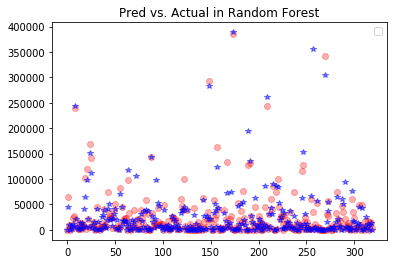

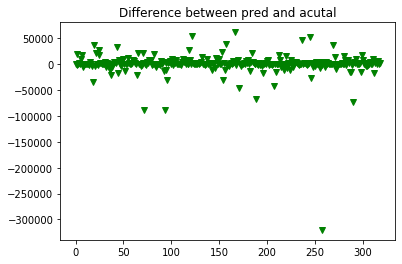

In [61]:
plot_diff(test_agg2, 'Pred vs. Actual in Random Forest', 'Difference between pred and acutal')

As the Random Forest model has better performance than the Lasso Linear Regression model, we will use the Ramdom Forest as our final forecasting model.

In [62]:
# re-train with training + test data (rf so no scaling needed)
new_ex_combine_1 = new_ex_combine.copy(deep = True)
new_ex_combine_1 = new_ex_combine_1.sample(frac = 1).reset_index(drop = True)
new_ex_combine_1_y = new_ex_combine_1['sales_amt']
new_ex_combine_1_X = new_ex_combine_1.drop(['sku', 'quarter', 'sales_amt'], axis = 1)

rf_best.fit(new_ex_combine_1_X, new_ex_combine_1_y)

# save model
# joblib.dump(rf_best, 'rf_best_co.sav', compress=3)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    3.8s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    4.6s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=55, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=6, oob_score=False,
                      random_state=2019, verbose=1, warm_start=False)

## Model for 87 New Products

It is a cold start for the 87 new products because they have no historical sales record. However, we can find existing products with sales data that are similar to the new products. And we can use those exsiting products to build a separate model for predicting the sales_amt of new products. I will use cosine similarity to get the most similar products.

In [0]:
# Align existing products' col names and new products' col names.
# new_ex_combine is the dataframe of existing products after feature preprocessing. It has sku, qrt, sales_amt, shelf_amt, and all categorical dummies.

similarity_prod_dummy = new_ex_combine.copy(deep=True)

In [0]:
# new products don't have quarter, season, year, location, shelf_amt and sales_amt, we drop these columns
similarity_prod_dummy = similarity_prod_dummy.drop(['quarter', 'sales_amt', 'shelf_amt', 'CANADA', 'GERMANY', 'INDIA', 'ITALY', 'JAPAN', 'KOREA', 'MEXICO',
       'RUSSIA', 'SPAIN', 'UNITED KINGDOM', 'UNITED STATES', '2014', '2015', '2016', 'FA', 'SP', 'SU', 'WI'], axis = 1)

In [0]:
# get unique rows for cosine similarity compare
# the original data was by sku, location and quarter but we dropped location and quarter. After deduplication we should have 320 unique existing skus
similarity_prod_dummy_dedup = similarity_prod_dummy.drop_duplicates()

# for later ID mapping
prod_ID = similarity_prod_dummy_dedup['sku']

# to operate cosine similarity
s_list = similarity_prod_dummy_dedup.drop(['sku'], axis = 1).values.tolist()

In [69]:
print ("Num of rows before deduplication: " + str(similarity_prod_dummy.shape[0])) # row count
print ("Num of rows after deduplication: " + str(similarity_prod_dummy_dedup.shape[0])) # row count
print ("Num of cols after deduplication: " + str(similarity_prod_dummy_dedup.shape[1]))

Num of rows before deduplication: 6942
Num of rows after deduplication: 320
Num of cols after deduplication: 160


In [70]:
print(similarity_prod_dummy_dedup.shape)
print(new_nw.shape)

(320, 160)
(87, 94)


The number of columns differ between the product and new data because of the different number of subcategories. We will make the number of columns the same for both data. 

- For any columns in new data but not in product, we drop those from new data
- For any columns in prodict data but not in new, we add columns with 0 values to new data

This will generate exact columns needed for the model we built

In [0]:
diff = list((set(new_nw.columns) - set(similarity_prod_dummy_dedup.columns)))
if len(diff)!=0:
    new_nw.drop(diff, axis = 1, inplace = True)

In [0]:
missing_cols = set(similarity_prod_dummy.columns) - set(new_nw.columns)
# For missing cols, add new column in test set with default value equal to 0
for m in missing_cols:
    new_nw[m] = 0

In [0]:
new_nw = new_nw[similarity_prod_dummy_dedup.columns] #make the order of columns the same

In [74]:
print(similarity_prod_dummy_dedup.shape)
print(new_nw.shape)

(320, 160)
(87, 160)


In [0]:
new_prod_ID = new_nw['sku']

s_new = new_nw.drop(['sku'], axis=1)
s_new_list = s_new.values.tolist()

prod_ID: a list of sku ids for existing 320 products\
new_prod_ID: a list of sku ids for new 87 products

s_list: a list of existing products data points\
s_new_list: a list of new products data points

In [0]:
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity

#total 87 lists in d_sim, each list has 320 cosine values

d_sim = defaultdict(list)

for i in range(len(new_prod_ID)):
    for j in range(len(prod_ID)):
        s_new_list[i] = np.array(s_new_list[i]).reshape(1,-1)
        s_list[j] = np.array(s_list[j]).reshape(1,-1)
        tmp_sim = float(cosine_similarity(s_new_list[i],s_list[j]))
        d_sim[i].append(tmp_sim)

In [77]:
len(d_sim)

87

In [0]:
d_sim

#86: [0.36514837167011077,
#              0.50709255283711,
#              0.18257418583505539,
#              0.18257418583505539,
#              0.3162277660168379,
#              0.36514837167011077,...]

In [0]:
# get the top 3 most similar products list with each new product
# because there can be duplications, we save the products into a set.
high_sim_prod_index = set()
for ID in range(87):
    tmp_3 = sorted(range(320), key=lambda i: d_sim[ID][i])[-3:]
    for p in tmp_3:
        high_sim_prod_index.add(p)
        
high_sim_prod_ID = prod_ID.iloc[list(high_sim_prod_index)]
# high_sim_prod_ID.tolist()

In [79]:
#chosen existing product ids
high_sim_prod_ID

5         37
144      266
187      285
212      324
318      573
        ... 
6789    9826
6903    9890
6913    9908
6919    9929
6923    9956
Name: sku, Length: 169, dtype: int64

In [80]:
similar_new_1 = ex_combine_1[ex_combine_1['sku'].isin(high_sim_prod_ID)]
print (similar_new_1.shape)

(3846, 13)


Feature Preprocessing

In [0]:
#sales_price
bin_price4 = [13, 44, 51, 58, 69, 77, 88, 101, 119, 143, 306]
price_label_name4 = ['<= $44', '$44-51', '$51-58', '$58-69', '$69-77', '$77-88', '$88-101', '$101-119', '$119-143', ' >= $143']
bin4 = pd.cut(similar_new_1['sales_price'], bin_price4, labels = price_label_name4) #the value of each row turned from certain price to one of the 10 buckets
d_price4 = pd.get_dummies(bin4)

# simple categorical features
d_location4 = pd.get_dummies(similar_new_1['location'])
d_age4 = pd.get_dummies(similar_new_1['age'])
d_formation4 = pd.get_dummies(similar_new_1['formation'])
d_family4 = pd.get_dummies(similar_new_1['family'])
d_brand4 = pd.get_dummies(similar_new_1['brand'])
d_year4 = pd.get_dummies(similar_new_1['year'])
d_season4 = pd.get_dummies(similar_new_1['season'])

#specs
d_spec4 = similar_new_1['specs'].str.get_dummies(sep='|')
temp4 = similar_new_1.drop(['sales_price', 'location', 'age', 'formation', 'family', 'brand', 'specs', 'season', 'year'], axis =1)
similar_new_2 = pd.concat([temp4, d_price4, d_location4, d_age4, d_formation4, d_family4, d_brand4, d_spec4, d_year4, d_season4], axis = 1)

Split Train/Test data

In [82]:
print ('SP2016 data points consists of', similar_new_2['quarter'][similar_new_2['quarter'] == 'SP2016'].count() / similar_new_2.shape[0] * 100, '% of overall data points')

SP2016 data points consists of 19.292771710868433 % of overall data points


In [0]:
# select ~20% latest data for test purpose
similar_new_2_test = similar_new_2[similar_new_2['quarter'] =='SP2016']
similar_new_2_train = similar_new_2[similar_new_2['quarter'] !='SP2016']

# prepare training and test data
similar_new_2_train = similar_new_2_train.sample(frac = 1).reset_index(drop = True)
similar_new_2_train_X = similar_new_2_train.drop(['sku','quarter','sales_amt'],axis = 1)
similar_new_2_train_y = similar_new_2_train['sales_amt'] 

similar_new_2_test_X = similar_new_2_test.drop(['sku','quarter','sales_amt'],axis = 1)
similar_new_2_test_y = similar_new_2_test['sales_amt'] 

In [84]:
similar_new_2_test_X.head(2)

,shelf_amt,<= $44,$44-51,$51-58,$58-69,$69-77,$77-88,$88-101,$101-119,$119-143,>= $143,CANADA,GERMANY,INDIA,ITALY,JAPAN,KOREA,MEXICO,RUSSIA,SPAIN,UNITED KINGDOM,UNITED STATES,ADULT,GRADE SCHOOL,PRE SCHOOL,TODDLER,capsule,liquid,powder,Calcium,...,Y585,Y83,Z362,Z762,Z778,Z966,PATENT 1030,PATENT 2461,PATENT 2876,PATENT 3279,PATENT 4090,PATENT 4533,PATENT 456,PATENT 4566,PATENT 5281,PATENT 5514,PATENT 5726,PATENT 6776,PATENT 7883,PATENT 8830,PATENT 8895,PATENT 8998,PATENT 9568,2014,2015,2016,FA,SP,SU,WI
6,7673,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0
11,2728,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0


Train Random Forest Model

In [0]:
grid_2 = {'n_estimators': [15,20,30,40,50,60,70,80],
          'max_depth': [5,10,20,30,40,50]}

rf_2 = RandomForestRegressor(random_state = 2019, verbose = 1, n_jobs = 6)
grid_rf_2 = GridSearchCV(rf_2, grid_2, cv = 3)
grid_rf_2.fit(similar_new_2_train_X, similar_new_2_train_y)

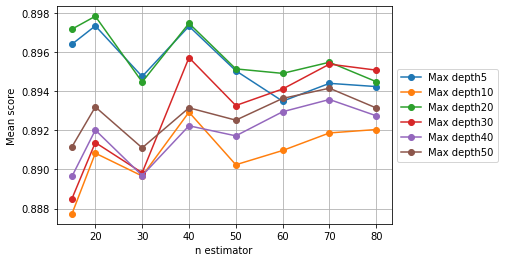

In [89]:
scores2 = grid_rf_2.cv_results_['mean_test_score']

n_estimators = [15,20,30,40,50,60,70,80]
m_depth = [5,10,20,30,40,50]
scores2 = np.array(scores2).reshape(len(m_depth), len(n_estimators))

fig = plt.figure()
ax = plt.subplot(111)
for idx, depth in enumerate(m_depth):
    plt.plot(n_estimators, scores2[idx], '-o', label = 'Max depth' + str(depth))
    
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('n estimator')
plt.ylabel('Mean score')
plt.grid(True)
plt.show()

In [90]:
print (grid_rf.best_params_)
print (grid_rf.best_score_)

{'max_depth': 55, 'n_estimators': 50}
0.8651492300079401


In [91]:
# re-train the model with full training set
rf_best_new = grid_rf_2.best_estimator_
rf_best_new.fit(similar_new_2_train_X, similar_new_2_train_y)
rf_best_new_pred = rf_best_new.predict(similar_new_2_test_X)
# save model
# joblib.dump(rf_best_new, 'rf_best_new.sav', compress=3)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished


In [0]:
# compare the aggreated prediction with actual sales
new_test_rf = similar_new_2_test.copy(deep=True)
new_test_rf['pred'] = np.round(rf_best_new_pred)
new_test_rf['pred'] = new_test_rf['pred'].clip(lower=0)

function_4 = {'sales_amt':'sum', 'pred':'sum'}
new_test_rf_agg = new_test_rf.groupby(['sku','quarter'], as_index = False).agg(function_4)

In [93]:
evaluate(new_test_rf_agg)

MAPE of prediction in SP2016 is 86.65345036105504
MAE of prediction in SP2016 is 	 10839.035714285714
MAD ratio of prediction in SP2016 is 1.0316126881874812
R squared of prediction in SP2016 is 0.7305859300728306
MSE of prediction in SP2016 is 849822492.8095238
RMSE of prediction in SP2016 is 29151.71509207518


No handles with labels found to put in legend.


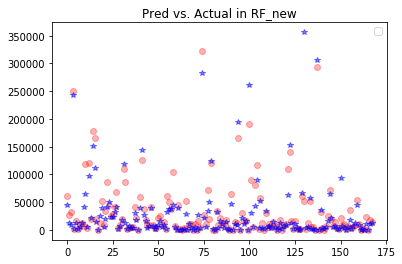

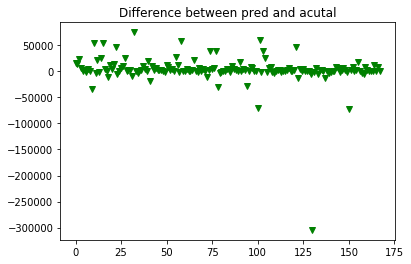

In [94]:
plot_diff(new_test_rf_agg, 'Pred vs. Actual in RF_new', 'Difference between pred and acutal')

# Part 4: Prediction

### 320 existing product prediction

The model for the 320 existing products take in total 178 features, including shelf_amt and the dummies interval of categorical features.

However, we lack the shelf_amt and the exact dummies (e.g. locations in which the products will be sold at) for SU2016.

Therefore we need to modify the independent variables for SU2016 existing products to align with what the model takes in as parameters before we can use the rf_best model to predict sales_amt.

In [0]:
predict_X = new_ex_combine.drop(['quarter','sales_amt'], axis=1)

In [0]:
#for the information the prediction data doesn't have, fill with 0 to keep training and test data (i.e. prediction data) the same shape and columns
for i in ['shelf_amt', 'CANADA', 'GERMANY', 'INDIA', 'ITALY', 'JAPAN', 'KOREA', 'MEXICO',
       'RUSSIA', 'SPAIN', 'UNITED KINGDOM', 'UNITED STATES', '2014', '2015', '2016', 'FA', 'SP', 'SU', 'WI']:
    predict_X[i] = 0

#specify that SUMMER 2016 is what we are interested in    
predict_X['SU'] = 1
predict_X['2016'] = 1

In [0]:
# we assume that every sku is sold at all 11 locations
appended_data = []
for i in ['CANADA', 'GERMANY', 'INDIA', 'ITALY', 'JAPAN', 'KOREA', 'MEXICO', 'RUSSIA', 'SPAIN', 'UNITED KINGDOM', 'UNITED STATES']:
          tmp = predict_X.copy(deep = True)
          tmp[i] = 1
          appended_data.append(tmp)

In [0]:
appended_data = pd.concat(appended_data)

In [103]:
appended_data

,sku,shelf_amt,<= $44,$44-51,$51-58,$58-69,$69-77,$77-88,$88-101,$101-119,$119-143,>= $143,CANADA,GERMANY,INDIA,ITALY,JAPAN,KOREA,MEXICO,RUSSIA,SPAIN,UNITED KINGDOM,UNITED STATES,ADULT,GRADE SCHOOL,PRE SCHOOL,TODDLER,capsule,liquid,powder,...,Z762,Z778,Z966,PATENT 1030,PATENT 2461,PATENT 2876,PATENT 3279,PATENT 4090,PATENT 4533,PATENT 456,PATENT 4566,PATENT 5281,PATENT 5514,PATENT 5726,PATENT 6776,PATENT 7883,PATENT 8830,PATENT 8895,PATENT 8924,PATENT 8998,PATENT 9404,PATENT 9545,PATENT 9568,2014,2015,2016,FA,SP,SU,WI
0,12,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,12,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,12,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,12,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,12,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6937,9974,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0
6938,9974,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0
6939,9974,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0
6940,9974,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0


In [0]:
predict_X2 = appended_data.drop_duplicates()

In [105]:
predict_X2

,sku,shelf_amt,<= $44,$44-51,$51-58,$58-69,$69-77,$77-88,$88-101,$101-119,$119-143,>= $143,CANADA,GERMANY,INDIA,ITALY,JAPAN,KOREA,MEXICO,RUSSIA,SPAIN,UNITED KINGDOM,UNITED STATES,ADULT,GRADE SCHOOL,PRE SCHOOL,TODDLER,capsule,liquid,powder,...,Z762,Z778,Z966,PATENT 1030,PATENT 2461,PATENT 2876,PATENT 3279,PATENT 4090,PATENT 4533,PATENT 456,PATENT 4566,PATENT 5281,PATENT 5514,PATENT 5726,PATENT 6776,PATENT 7883,PATENT 8830,PATENT 8895,PATENT 8924,PATENT 8998,PATENT 9404,PATENT 9545,PATENT 9568,2014,2015,2016,FA,SP,SU,WI
0,12,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
5,37,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
55,81,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
69,147,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
79,206,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6903,9890,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
6913,9908,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0
6919,9929,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0
6923,9956,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


In [106]:
# make prediction at sku/location level
predict_y = rf_best.predict(predict_X2.drop(['sku'], axis=1))

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished


In [0]:
# format the final output for existing product
pred_output = pd.DataFrame()
pred_output['sku'] = predict_X2['sku']
pred_output['quarter'] = 'SU2016'
pred_output['pred_sales'] = np.around(predict_y, decimals = 0) # round to 0 decimal

In [109]:
pred_output

,sku,quarter,pred_sales
0,12,SU2016,16.000
5,37,SU2016,92.000
55,81,SU2016,95.000
69,147,SU2016,7.000
79,206,SU2016,8.000
...,...,...,...
6903,9890,SU2016,44.000
6913,9908,SU2016,13.000
6919,9929,SU2016,11.000
6923,9956,SU2016,44.000


In [0]:
# aggregate at sku level only, i.e. sum all locations per sku
function_5 = {'pred_sales' : 'sum'}
pred_output= pred_output.groupby(['sku','quarter'], as_index = False).agg(function_5)

In [111]:
pred_output

,sku,quarter,pred_sales
0,12,SU2016,184.000
1,37,SU2016,1022.000
2,81,SU2016,975.000
3,147,SU2016,95.000
4,206,SU2016,1612.000
...,...,...,...
315,9890,SU2016,322.000
316,9908,SU2016,1550.000
317,9929,SU2016,143.000
318,9956,SU2016,214.000


### 87 new product prediction

The model for the 87 new products was trained using existing products' features. We need to modify the new_nw dataframe to match the columns in the training dataset (similar_new_2)

In [0]:
#new_nw is the dataset after feature preprocessing
new_predict_X = new_nw.copy(deep = True)

In [0]:
#for whatever col new_predict_X doesn't have, we will add on with value 0
#but we need to care take of locations separately because we want the products to be sold at each of the 11 locations, thus values need to be 1
for i in ['CANADA', 'GERMANY', 'INDIA', 'ITALY', 'JAPAN', 'KOREA', 'MEXICO', 'RUSSIA', 'SPAIN', 'UNITED KINGDOM', 'UNITED STATES']:
          new_predict_X[i] = 0

appended_data2 = []

for i in ['CANADA', 'GERMANY', 'INDIA', 'ITALY', 'JAPAN', 'KOREA', 'MEXICO', 'RUSSIA', 'SPAIN', 'UNITED KINGDOM', 'UNITED STATES']:
          tmp = new_predict_X.copy(deep = True)
          tmp[i] = 1
          appended_data2.append(tmp)

In [0]:
appended_data2 = pd.concat(appended_data2)
new_predict_X2 = appended_data2.drop_duplicates()

In [0]:
new_predict_X2_sku = new_predict_X2['sku']

In [0]:
# find if any new dummy columns show up, if yes, delete them, since they do not exist in training data
diff_new = list((set(new_predict_X2.columns) - set(similar_new_2_train_X.columns)))
if len(diff_new) != 0:
    new_predict_X2.drop(diff_new, axis = 1, inplace =True)

In [0]:
# Get missing columns in the training data 'similar_new_2_train_X', including shelf_amt, 2014, 2015, 2016 and season names
missing_cols_new = set(similar_new_2_train_X.columns) - set(new_predict_X2.columns)
# Add a missing column in test set with default value equal to 0
for s in missing_cols_new:
    new_predict_X2[s] = 0

In [118]:
print(similar_new_2_train_X.shape)
print(new_predict_X2.shape) #more than 87 because we have added multiple locations

(3104, 133)
(957, 133)


In [119]:
new_predict_X2

,<= $44,$44-51,$51-58,$58-69,$69-77,$77-88,$88-101,$101-119,$119-143,>= $143,ADULT,GRADE SCHOOL,PRE SCHOOL,TODDLER,capsule,liquid,powder,Calcium,Cranberry,Echinacea,FishOil,Ginger,Ginseng,GreenTea,Magnesium,Melatonin,MilkThistle,Omega3FattyAcid,Valerian,VitaminC,...,PATENT 456,PATENT 4566,PATENT 5281,PATENT 5514,PATENT 5726,PATENT 6776,PATENT 7883,PATENT 8830,PATENT 8895,PATENT 8998,PATENT 9568,CANADA,GERMANY,INDIA,ITALY,JAPAN,KOREA,MEXICO,RUSSIA,SPAIN,UNITED KINGDOM,UNITED STATES,SU,2016,2014,WI,2015,shelf_amt,FA,SP
5,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
370,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
374,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
385,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [0]:
# above is just to get the cols aligned
# now since we know the year is 2016, and season is SU, we need to re-value them    
new_predict_X2['shelf_amt'] = 0    #already 0 actually
new_predict_X2['2016'] = 1
new_predict_X2['SU'] = 1
new_predict_X2 = new_predict_X2[similar_new_2_train_X.columns.tolist()] # make sure the column order is same

In [121]:
new_predict_y = rf_best_new.predict(new_predict_X2)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished


In [0]:
# format the final output for new product
new_pred_output = pd.DataFrame()
new_pred_output['sku'] = new_predict_X2_sku
new_pred_output['quarter'] = 'SU2016'
new_pred_output['pred_sales'] = np.around(new_predict_y, decimals = 0) # round to 0 decimal

In [0]:
# aggregate at sku level only, i.e. sum all locations per sku
function_6 = {'pred_sales' : 'sum'}
new_pred_output= new_pred_output.groupby(['sku', 'quarter'], as_index = False).agg(function_6) 

In [125]:
new_pred_output

,sku,quarter,pred_sales
0,13,SU2016,3145.000
1,37,SU2016,2613.000
2,285,SU2016,3388.000
3,323,SU2016,220.000
4,525,SU2016,194.000
...,...,...,...
82,9581,SU2016,6000.000
83,9615,SU2016,430.000
84,9685,SU2016,1150.000
85,9693,SU2016,589.000


Combine the predicted SU2016 sales_amt of both existing and new products into one file

In [0]:
df_predict1 = df_predict.copy(deep = True)

In [0]:
#[existing] left join df_predict1 with pred_output, remove na and clean columns
df_predict_ex = df_predict1.merge(pred_output, on = ['sku'], how = 'left')
df_predict_ex_removena = df_predict_ex.dropna()
df_predict_ex_removena = df_predict_ex_removena.drop(['quarter_x'], axis = 1)
df_predict_ex_removena = df_predict_ex_removena.rename(columns={'quarter_y': 'quarter'})

In [0]:
#[new] left join df_predict1 with new_pred_output, remove na and clean columns
df_predict_new = df_predict1.merge(new_pred_output, on = ['sku'], how = 'left')
df_predict_new_removena = df_predict_new.dropna()
df_predict_new_removena = df_predict_new_removena.drop(['quarter_x'], axis = 1)
df_predict_new_removena = df_predict_new_removena.rename(columns={'quarter_y': 'quarter'})

In [0]:
#concat existing and new
df_predict_final = pd.concat([df_predict_ex_removena, df_predict_new_removena])

In [137]:
df_predict_final

,sku,quarter,pred_sales
0,8852,SU2016,864.000
1,3403,SU2016,182.000
2,7584,SU2016,293.000
3,2057,SU2016,900.000
4,3686,SU2016,89.000
...,...,...,...
385,7158,SU2016,140.000
388,4294,SU2016,220.000
391,5642,SU2016,500.000
398,7980,SU2016,3275.000


In [0]:
# Write dataframe into csv file

df_predict_final.to_csv('prediction_SU2016')

# Part 5: Feature Selection

What are the most important features that attribute to sales_amt? The Random Forest model shows the best prediction accuracy. Therefore, the feature importance will be extracted from the RF model.

In [0]:
importances = rf_best.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_best.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
feature_name = X_test.columns

In [96]:
print("Feature importance ranking:")

for f in range(X_test.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f],  feature_name[f], importances[indices[f]]))

Feature importance ranking:
1. feature 0 shelf_amt (0.835132)
2. feature 6 <= $44 (0.032790)
3. feature 152 $44-51 (0.013169)
4. feature 146 $51-58 (0.012183)
5. feature 39 $58-69 (0.007968)
6. feature 56 $69-77 (0.007206)
7. feature 155 $77-88 (0.007187)
8. feature 10 $88-101 (0.006964)
9. feature 7 $101-119 (0.006384)
10. feature 156 $119-143 (0.004696)
11. feature 174  >= $143 (0.004135)
12. feature 175 CANADA (0.003755)
13. feature 171 GERMANY (0.002774)
14. feature 173 INDIA (0.002706)
15. feature 22 ITALY (0.002582)
16. feature 177 JAPAN (0.002556)
17. feature 29 KOREA (0.002501)
18. feature 176 MEXICO (0.002469)
19. feature 8 RUSSIA (0.002210)
20. feature 20 SPAIN (0.001985)
21. feature 164 UNITED KINGDOM (0.001811)
22. feature 23 UNITED STATES (0.001566)
23. feature 172 ADULT (0.001491)
24. feature 25 GRADE SCHOOL (0.001335)
25. feature 1 PRE SCHOOL (0.001299)
26. feature 65 TODDLER (0.001237)
27. feature 134 capsule (0.001231)
28. feature 46 liquid (0.001223)
29. feature 17 po

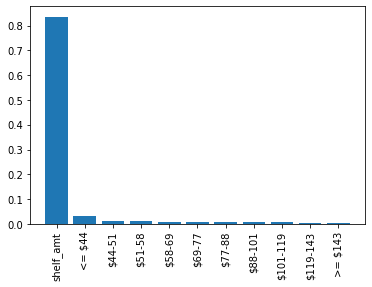

In [97]:
# Print the feature ranking
plt.bar(feature_name[:11], importances[indices[:11]])
plt.xticks(rotation=90)
plt.show()

Lasso feature selection with coefficient

In [98]:
#lasso_f.coef_

print ("Lasso Coefficients")
for coef, col_name in sorted(zip(map(lambda x: round(x, 4), lasso_f.coef_), X_test.columns), key = lambda pair:(abs(pair[0])), reverse = True):
  print (col_name, ": \t", str(coef))

Lasso Coefficients
PATENT 2461 : 	 15711.1082
PATENT 8895 : 	 -14871.5002
H100 : 	 -8796.7534
V891 : 	 -8662.3529
C317 : 	 -7486.5134
G28 : 	 -7145.9594
H654 : 	 6911.6891
P544 : 	 -5756.2679
E934 : 	 -5668.5046
K107 : 	 -5658.1545
SawPalmetto : 	 5656.6409
$77-88 : 	 5524.1525
PATENT 5281 : 	 5453.7502
Q889 : 	 5243.8815
C332 : 	 -5182.0265
MilkThistle : 	 4699.0851
K831 : 	 -4576.9197
Y266 : 	 -4542.1822
E298 : 	 4289.3536
C319 : 	 -4081.4633
Y352 : 	 -3773.9228
R16 : 	 3618.4274
V237 : 	 3355.2476
I562 : 	 -3319.254
X471 : 	 3304.7926
U117 : 	 -3171.3377
G633 : 	 -3162.6224
Omega3FattyAcid : 	 -3103.8835
F792 : 	 2993.0613
H216 : 	 -2982.8325
Y585 : 	 -2915.499
PATENT 9404 : 	 -2882.9532
M598 : 	 2859.6188
Cranberry : 	 -2791.4092
X886 : 	 2771.1947
W754 : 	 -2692.0745
shelf_amt : 	 2678.327
Y493 : 	 -2622.2414
Y481 : 	 2608.7435
ITALY : 	 -2556.4904
Calcium : 	 -2508.3159
S872 : 	 -2338.0421
J957 : 	 2327.6184
Y83 : 	 2233.2928
I152 : 	 2201.79
FishOil : 	 -2181.0497
TODDLER : 	 21

Shelf_amt, sales_price, and location are among the top features according to feature importance.